# MONEYBALL 

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

In [182]:
def add_feature(df):
    # 1B stats
    df['1B'] = df['H'] - (df['2B'] + df['3B'] + df.HR)
    # At Bat per Homerun
    df['ABHR'] = round(df['AB'] / df['HR'],3)
    # AVG (H/AB)
    df['AVG'] = round(df['H'] / df['AB'],3)
    # On Base Percentage
    df['OBP'] = round(
        (df.H + df.BB + df.HBP) / 
        (df.AB + df.BB + df.HBP + df.SF),3)
    # Slugging rate
    df['SLG'] = round(
        (df['1B'] + df['2B']*2 + df['3B']*3 + df['HR']*4) / 
        df.AB, 3)
    # OBP Plus SLG
    df['OPS'] = df.OBP + df.SLG
    try:
        # FIP
        df['FIP'] = ((df.HRA*13 + (df.BBA+df.PHBP)*3 - df.SOA*2)) / df.IPouts + df.cFIP
        #WHIP
        df['WHIP'] = (df.HA + df.BBA) / (df.IPouts/3)
    except:
        pass


The data is from Lahman's Baseball Database, which you can get access for free on their website.

    -> https://www.seanlahman.com/baseball-archive/statistics/

In [183]:
df_player = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/core/People.csv')
df_salaries = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/contrib/Salaries.csv')
df_batting = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/core/Batting.csv')
df_pitching = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/core/Pitching.csv')
df_team = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/core/Teams.csv')
df_post = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/lahman/core/PitchingPost.csv')

df_w = pd.read_csv('/Users/jinc/Desktop/프로젝트/baseball_analysis/baseball_analysis/Batting_Pitching_Fielding/data/fangraph_weight.csv')

In [184]:
PHBP = df_pitching.groupby(['yearID','teamID'])['HBP'].sum().reset_index()
PHBP.rename(columns={'HBP':'PHBP'},inplace=True)
df_team = df_team.merge(PHBP, how='left',on=['yearID','teamID'])
df_team = df_team.merge(df_w, how='left', left_on='yearID', right_on='Season')

In [185]:
df_team.pipe(add_feature)
df_batting.pipe(add_feature)

Moneyball is one of my best movie that explains the importance of data driven decision. 
In this notebook, we will go through the steps that Billy Beane and Paul DePodesta took, so that we can understand how they were able to take there team to the playoffs. And to understand how the process of data analysis work.

## How to make it to the Playoffs?

The first question they encountered was 

- How do we get to the playoffs?

### Salary

However, Oakland A's were extreamly limited with budget for payroll. With approximately 40 million dollar in salary, they were suppose to compete with larger market teams, such as the Yankees with 125 million dollar in payroll during the 2002 baseball season.

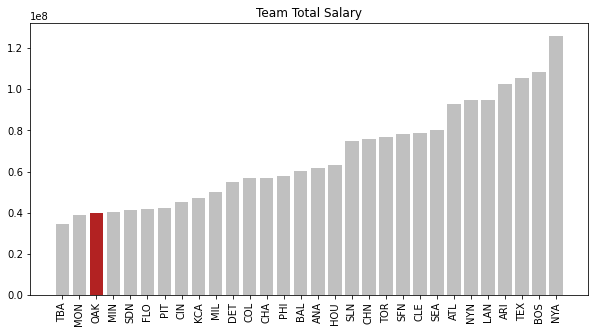

In [186]:
team_salary = df_salaries[df_salaries.yearID == 2002][['teamID','salary']].groupby('teamID').sum().sort_values(by=['salary'])
colors = ['firebrick' if i == 'OAK' else 'silver' for i in team_salary.index]
plt.figure(figsize=(10,5))
plt.title('Team Total Salary')
plt.bar(team_salary.index, team_salary.salary, color=colors)
plt.xticks(rotation=90)
plt.show()

### Replacing Key Players

The A's also needed to replace their key star players, Johnny Damon(CF) and **Jason Giambi(1B)** who were leaving the team.

In [187]:
# Let's see the batting average and at bat per homerun 
# of these three players in the previous season.
a = df_batting[(df_batting.yearID == 2001)].copy()
batting = a[['playerID','teamID','ABHR','AVG','OBP','SLG','OPS']]
player = df_player[['playerID','nameFirst','nameLast']]

# # At Bat per Homerun
# batting['ABHR'] = round(a['AB'] / a['HR'],3)

# AVG (H/AB)
# batting['AVG'] = round(a['H'] / a['AB'],3)

# salaries
batting = batting.merge(df_salaries[df_salaries.yearID==2002],
                        how='left',on='playerID')

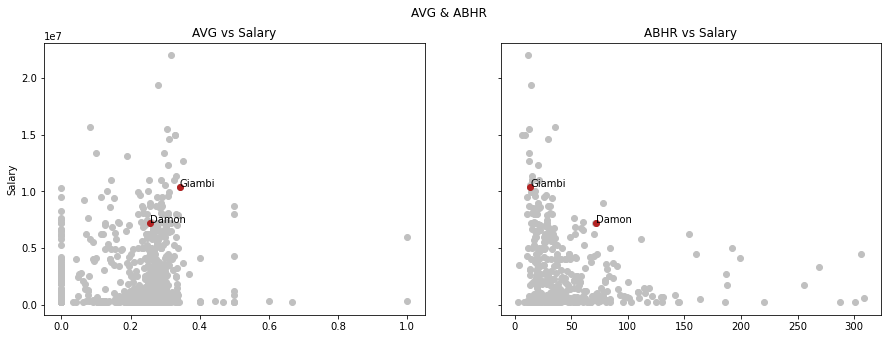

In [188]:
# batting = batting[batting.ABHR != np.inf]
batting = batting.dropna()
f,ax = plt.subplots(1,2,figsize=(15,5))
plt.suptitle('AVG & ABHR')
ax[0].set_title('AVG vs Salary')
ax[1].set_title('ABHR vs Salary')
ax[0].set_ylabel('Salary')
ax[1].label_outer()
ax[0].scatter(batting.AVG, batting.salary, color='silver')
ax[1].scatter(batting.ABHR, batting.salary, color='silver')

key = ['damonjo01','giambja01']
batting_key = batting[batting.playerID.isin(key)]
ax[0].scatter(batting_key.AVG, batting_key.salary, color='firebrick')
ax[1].scatter(batting_key.ABHR, batting_key.salary, color='firebrick')

names = ['Damon', 'Giambi']
for i, col in enumerate(['AVG','ABHR']):
    for j, name in enumerate(names):
        ax[i].annotate(name,(batting_key[col].values[j], batting_key.salary.values[j]))
    
plt.show()

Batting average and homerun rates were 2 important feature that evaluated batter's performance during the period and was over valued. Thus, the Oakland A's could not afford high priced homerun hitters with high batting average like Giambi and Damon

So, the question is rewritten:

- How do we make a team that can get to the playoffs with limited budget?

### Wins / Runs to Playoff

**"Your goal shouldn't be to buy players. Your goal should be to buy wins and in order to buy wins, you need to buy runs."**

    
    -Moneyball

Beane and DePodestas' goal was to have the Oakland A's to the playoffs. In the movie, they predicted that they needed approximately 95 wins to be qualified for the playoffs.

In [189]:
# create feature post
# made to playoff = 1
post = df_post[['yearID','teamID']].copy()
post = post.drop_duplicates(subset=['yearID','teamID'], keep='first')
post['post'] = 1
# merge with team database
team = df_team[['yearID','teamID','W','L','R','RA','AVG','ABHR','OBP','SLG','OPS']].copy()
team = team.merge(post, how='left',on=['yearID','teamID'])
team = team.fillna(0)

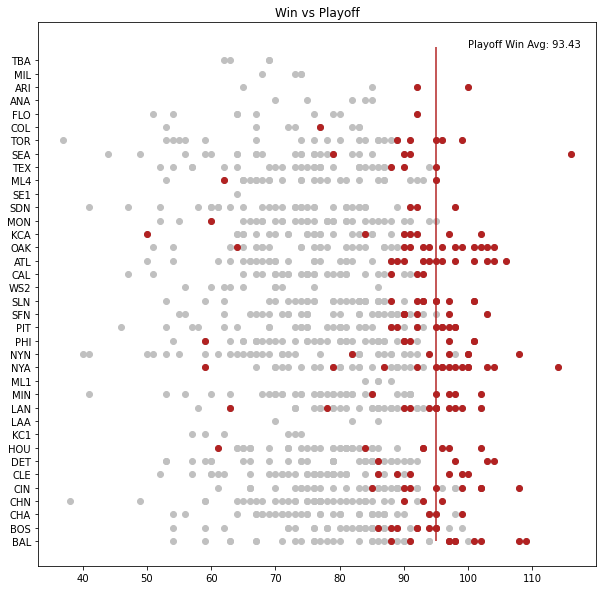

In [190]:
# It is known that DePodesta used data from 1962 to 2001
a = team[(team.yearID >= 1962)&(team.yearID <= 2001)].copy()
b = a[a.post == 1]
plt.figure(figsize=(10,10))
plt.title('Win vs Playoff')
plt.scatter(a.W, a.teamID, color='silver')
plt.scatter(b.W, b.teamID, color='firebrick')

# 95 wins line
plt.vlines(95,0,a.teamID.nunique(),color='firebrick')
plt.text(100, a.teamID.nunique(), f'Playoff Win Avg: {round(b.W.mean(),2)}')
plt.show()

95 Runs seems to be quite accurate.

Now, lets see how many runs they needed to get 95 wins.

In [191]:
rd = team['R'] - team['RA']
team.insert(6, 'RD', rd)

In [192]:
a = team[(team.yearID >= 1962)&(team.yearID <= 2001)].copy()
X = a.RD.values.reshape(-1,1)
y = a.W.values.reshape(-1,1)

lr = LinearRegression()
lr = lr.fit(X,y)
print(f'coef: {lr.coef_[0][0]}\nintercept: {lr.intercept_[0]}')
print('R2:', lr.score(X,y))

coef: 0.10513227913898428
intercept: 79.18650793650794
R2: 0.6851600019759458


In [193]:
# prediction for RD needed for 95 wins
result = round(lr.predict([[135]])[0][0],2)
print('Wins from 135 RD: ',result)

Wins from 135 RD:  93.38


DePodesta predicted that they needed 135 RD(Run Difference) to get 95 wins. 

However, the result seems to be quite off and shows relatively low RSquared score.

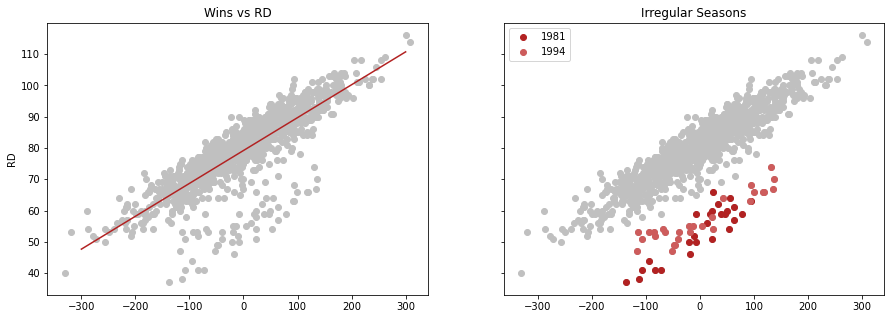

In [194]:
coef = lr.coef_[0][0]
inter = lr.intercept_[0]
a1981 = a[a.yearID == 1981]
a1994 = a[a.yearID == 1994]

f,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Wins vs RD')
ax[1].set_title('Irregular Seasons')
ax[0].set_ylabel('RD')
ax[1].label_outer()

ax[0].scatter(a.RD, a.W, color='silver')
ax[0].plot([-300,300], [coef*(-300)+inter, coef*300+inter], color='firebrick')

ax[1].scatter(a.RD, a.W, color='silver')
ax[1].scatter(a1981.RD, a1981.W, color='firebrick', label='1981')
ax[1].scatter(a1994.RD, a1994.W, color='indianred', label='1994')

ax[1].legend()
plt.show()

As you can see from the plot, 1981 and 1994 season observations are out of the pile.

It turned out that there were Major League Baseball Strikes in 1981 and 1994, which shortened the seasons.

In [195]:
# drop 1981 and 1994 seasons
a = a[a.yearID.isin([1981,1994])==False]
X = a.RD.values.reshape(-1,1)
y = a.W.values.reshape(-1,1)

lr = LinearRegression()
lr = lr.fit(X,y)
print(f'coef: {lr.coef_[0][0]}\nintercept: {lr.intercept_[0]}')
print('R2:', lr.score(X,y))

result = round(lr.predict([[135]])[0][0],2)
print('Wins from 135 RD: ',result)

coef: 0.10541204175996782
intercept: 80.53668763102725
R2: 0.8608294714878817
Wins from 135 RD:  94.77


In [196]:
# drop 1981 and 1994 seasons
a = a[a.yearID.isin([1981,1994])==False]
X = a.RD.values.reshape(-1,1)
y = a.W.values.reshape(-1,1)

lr = LinearRegression()
lr = lr.fit(X,y)
print(f'coef: {lr.coef_[0][0]}\nintercept: {lr.intercept_[0]}')
print('R2:', lr.score(X,y))

result = round(lr.predict([[135]])[0][0],2)
print('Wins from 135 RD: ',result)

coef: 0.10541204175996782
intercept: 80.53668763102725
R2: 0.8608294714878817
Wins from 135 RD:  94.77


Now, it looks accurate!

And our model looks like:

    Wins ~ 80.5367 + 0.1054(RD)

## Predicting Runs Difference

Now we got the model for Wins prediction, how do we predict runs?

### Feature Selection

### 1) Runs Scored 

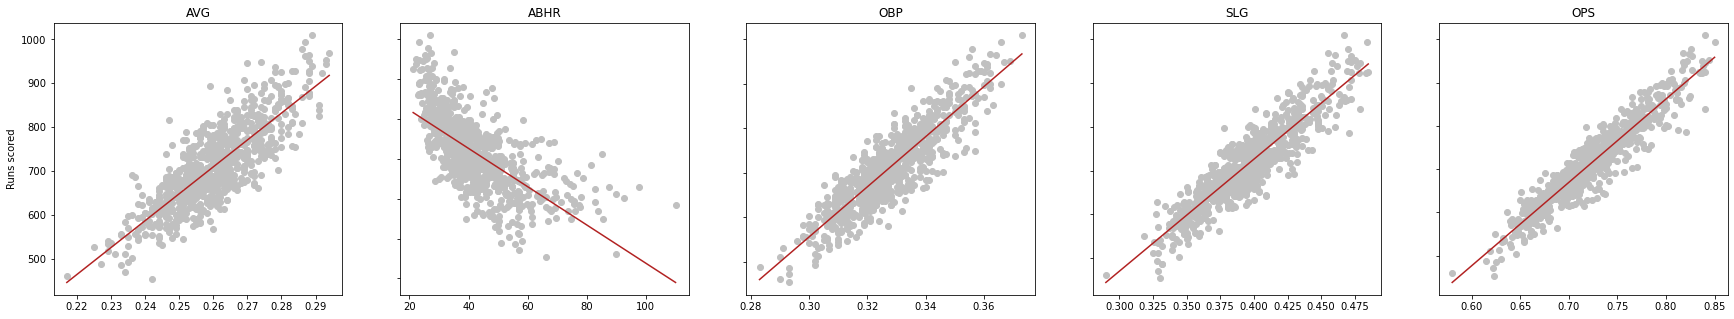

In [197]:
# HBP, stat that is needed for calculating OBP,
# started recording from the year 1970
year = np.arange(1970,2002)
a = df_team[df_team.yearID.isin(year)]
a = a[a.yearID.isin([1981,1994])==False]
cols = ['AVG','ABHR','OBP','SLG','OPS']

f,ax = plt.subplots(1,5,figsize=(30,5))
ax[0].set_ylabel('Runs scored')

for i,col in enumerate(cols):
    X = a[col].values.reshape(-1,1)
    y = a['R'].values.reshape(-1,1)
    min = a[col].min()
    max = a[col].max()
    lr = LinearRegression()
    lr = lr.fit(X,y)
    coef = lr.coef_[0][0]
    inter = lr.intercept_[0]
    ax[i].scatter(a[col], a.R, color='silver')
    ax[i].plot([min,max], [coef*min+inter, coef*max+inter], color='firebrick')
    ax[i].set_title(col)
    ax[i].label_outer()

plt.show()

In [198]:
smf.ols(formula='R ~ AVG + ABHR + OBP + SLG + OPS', data=a).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1757.
Date:                Sun, 29 May 2022   Prob (F-statistic):               0.00
Time:                        01:19:01   Log-Likelihood:                -3784.8
No. Observations:                 790   AIC:                             7580.
Df Residuals:                     785   BIC:                             7603.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -818.0155     29.880    -27.377      0.000    -876.670    -759.361
AVG         -128.7253    215.781     -0.597      0.551    -552.302     294.851
ABHR          -0.0155      0.181     -0.086      0.931      -0.370       0.339
OBP         1385.8812    108.531     12.769      0.000    1172.835    1598.927
SLG           97.8559     95.480      1.025      0.306     -89.570     285.282
OPS         1483.7371     54.907     27.023      0.000    1375.955    1591.519
==============================================================================
Omnibus:                       47.639   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.937
Skew:                          -0.498   Prob(JB):                     1.77e-15
Kurtosis:                       4.036   Cond. No.                     1.07e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.37e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We can see that out of the 5 features(AVG, ABHR, OBP, SLG, OPS), OPS and OBP are the best predictor. We can also see that there are some values with high p-value(no significant relation). So, we will be using Backward Elimination to find the best combination of predictors.

In [199]:
# Backward Elimination
values = ['AVG','ABHR','OBP','SLG','OPS']
elimination = True
while elimination == True:
    formula = ' + '.join(values)
    fit = smf.ols(formula = f'R ~ {formula}', data=a).fit()

    if fit.pvalues.sort_values(ascending=False)[0] > 0.05:
        val = fit.pvalues.sort_values(ascending=False).index[0]
        values.remove(val)

    else:
        elimination = False

smf.ols(formula = f'R ~ {formula}', data=a).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     3520.
Date:                Sun, 29 May 2022   Prob (F-statistic):               0.00
Time:                        01:19:01   Log-Likelihood:                -3785.1
No. Observations:                 790   AIC:                             7576.
Df Residuals:                     787   BIC:                             7590.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -826.5491     25.698    -32.164      0.000    -876.993    -776.105
OBP         1234.7444    163.665      7.544      0.000     913.473    1556.016
OPS         1570.2592     52.525     29.895      0.000    1467.153    1673.365
==============================================================================
Omnibus:                       46.614   Durbin-Watson:                   1.407
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.923
Skew:                          -0.492   Prob(JB):                     4.84e-15
Kurtosis:                       4.017   Cond. No.                         211.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our final model for RS(runs scored) is 

    RS ~ -826.5491 + 1234.7444(OBP) + 1570.2592(OPS)

### 2) Runs Allowed

We will go through the same process with RA(runs allowed) also

In [200]:
# Backward Elimination
values = ['SOA','ERA','FIP','WHIP']
elimination = True
while elimination == True:
    formula = ' + '.join(values)
    fit = smf.ols(formula = f'R ~ {formula}', data=a).fit()

    if fit.pvalues.sort_values(ascending=False)[0] > 0.05:
        val = fit.pvalues.sort_values(ascending=False).index[0]
        values.remove(val)

    else:
        elimination = False

smf.ols(formula = f'R ~ {formula}', data=a).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     138.1
Date:                Sun, 29 May 2022   Prob (F-statistic):           7.25e-72
Time:                        01:19:01   Log-Likelihood:                -4525.2
No. Observations:                 790   AIC:                             9058.
Df Residuals:                     786   BIC:                             9077.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    415.2471     74.240      5.593      0.000     269.516     560.978
ERA           41.6325     15.430      2.698      0.007      11.344      71.922
FIP          189.2296     17.638     10.729      0.000     154.607     223.852
WHIP        -349.3743     73.693     -4.741      0.000    -494.033    -204.716
==============================================================================
Omnibus:                        8.913   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                7.383
Skew:                           0.157   Prob(JB):                       0.0249
Kurtosis:                       2.646   Cond. No.                         211.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And our final model for RA is 

    RA ~ 415.2471 + 41.6325(ERA) + 189.2296(FIP) + -349.3743(WHIP)

### Prediction

In [201]:
# RS
# get roster from 2002
roster = df_batting[df_batting.yearID == 2002][df_batting.teamID == 'OAK'].dropna()
# relate stats from prev season
prev = df_batting[df_batting.yearID == 2001][df_batting['playerID'].isin(roster.playerID)]
cols = ['H','BB','HBP','AB','SF','1B','2B','3B','HR']
stats = []
for i in cols:
    stats.append(prev[i].sum())

stats = pd.DataFrame(stats, index=cols).T
stats.pipe(add_feature)
stats[]

,H,BB,HBP,AB,SF,1B,2B,3B,HR,ABHR,AVG,OBP,SLG,OPS
0,1632.0,646.0,89.0,6277.0,59.0,1022.0,356.0,29.0,225.0,27.898,0.26,0.335,0.433,0.768


Suppose that players from 2002 season will perform similarly to 2001 season. Then the Oakland A's will get **SLG** of **0.433** and **OPS** of **0.768**.